# ML for optimal sideband cooling
There are two optimization in multiorder sideband cooling: pulse schedule (time of each laser pulse) and what order RSB is applied.

1) Optimal sideband cooling pulse times can take a long time to compute, but funcitonally they look quite smooth and only rely on a few easily measured/calculated parameters. Could machine learning bridge the gap instead of a direct minimzation?

2) Determining when to apply what order RSB is an exponentially hard problem, yet it seems to follow a "block" ordering (highest orders first; first-order last). Can ML be used to estimate the optimal sequence of RSB orders instead of brute force optimizing over an exponential problem?

What ML models should we use? Neural Network would work, but since we want to predict a varying number of pulse timings, the number of output nodes would need to vary as well. That doesn't sound like a good fit.

SVM is a rising trend. We could use the regression version SVR to predict pulse times of a fixed strategy.

In [3]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

from sideband_cooling import simulation

## SVR for Fixed method 1st order RSB
Predict optimal pulse time given: eta, pi/omega, initial nbar, and number of pulses


Generate data set

In [19]:
N_rand = 5000

omegas = 2*np.pi * np.linspace(1/(2 * 1e-6), 1/(2 * 50e-6), 100)
omega_rands = np.random.choice(omegas, N_rand)

# Assume eta and initial nbar are computable from confining harmonic frequency omega_z
omega_zs = 2*np.pi * np.linspace(0.25, 6, 100) * 1e6
omega_z_rands = np.random.choice(omega_zs, N_rand)

lam = 355e-9
hbar = 1.05457e-34
m = 170.936 * 1.6605e-27
eta_rands = np.sqrt(2) * 2*np.pi/lam * np.sqrt(hbar/2/m/omega_z_rands)

initial_nbar_rands = 19.6e6/2/(omega_z_rands/2/np.pi)

N_pulses_rands = np.random.choice(np.arange(5, 50), N_rand)

strategy = 'fixed'
cooled_nbars = []
pulse_schedules = []
for omega_z, initial_nbar, omega, N_pulses in tqdm(zip(omega_z_rands, initial_nbar_rands, omega_rands, N_pulses_rands), total=len(omega_z_rands)):
    sim = simulation.SidebandCooling(omega_z, initial_nbar, omega)
    cooled_nbar, pulse_schedule, cooling_time, cooled_dist = sim.cool(strategy, N_pulses, 1)
    cooled_nbars.append(cooled_nbar)
    pulse_schedules.append(pulse_schedule[0])
    sim.reset_current_dist()

# Simulate and save data
pi_times = np.pi / omega_rands
dataX = np.column_stack((eta_rands, pi_times, initial_nbar_rands, N_pulses_rands))
dataY = np.array(pulse_schedules)

100%|██████████| 5000/5000 [30:22<00:00,  2.74it/s]


In [21]:
# Save data into files
with open('data/dataX_fixed.npy', 'wb') as f:
    np.save(f, dataX)
with open('data/dataY_fixed.npy', 'wb') as f:
    np.save(f, dataY)

In [22]:
# load saved data
with open('data/dataX_fixed.npy', 'rb') as f:
    dataX = np.load(f)
with open('data/dataY_fixed.npy', 'rb') as f:
    dataY = np.load(f)

Preprocess data with a 1/3 test-train split and scale X and y

In [23]:
# Preprocess data
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42)

scalerX = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
X_train = scalerX.transform(X_train)
y_train = (scalery.transform(y_train.reshape(-1,1))).reshape(-1,)
X_test = scalerX.transform(X_test)
y_test = (scalery.transform(y_test.reshape(-1,1))).reshape(-1,)


Use cross-validation to tune SVR hyperparameters

In [26]:
svr = svm.SVR()

# select variety of SVR hyperparameters to try out
param_grid = [{'C': [10, 100, 1000, 5000, 10000], 'gamma': [0.005, 0.0075, 0.01, 0.02, 0.03, 0.04], 'kernel': ['rbf']}]
svr_grid = GridSearchCV(svr, param_grid, scoring='r2')
svr_grid.fit(X_train, y_train)

means = svr_grid.cv_results_['mean_test_score']
stds = svr_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr_grid.cv_results_['params']):
    print("%0.4f (+/-%0.04f) for %r"
          % (mean, std * 2, params))
print("Best parameters set found on development set:\n")
print(svr_grid.best_params_,"\n")
print("Grid scores on development set:\n")

0.9527 (+/-0.0121) for {'C': 10, 'gamma': 0.005, 'kernel': 'rbf'}
0.9661 (+/-0.0075) for {'C': 10, 'gamma': 0.0075, 'kernel': 'rbf'}
0.9743 (+/-0.0029) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.9857 (+/-0.0021) for {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}
0.9890 (+/-0.0020) for {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}
0.9904 (+/-0.0023) for {'C': 10, 'gamma': 0.04, 'kernel': 'rbf'}
0.9832 (+/-0.0021) for {'C': 100, 'gamma': 0.005, 'kernel': 'rbf'}
0.9872 (+/-0.0026) for {'C': 100, 'gamma': 0.0075, 'kernel': 'rbf'}
0.9895 (+/-0.0029) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.9932 (+/-0.0025) for {'C': 100, 'gamma': 0.02, 'kernel': 'rbf'}
0.9954 (+/-0.0012) for {'C': 100, 'gamma': 0.03, 'kernel': 'rbf'}
0.9955 (+/-0.0017) for {'C': 100, 'gamma': 0.04, 'kernel': 'rbf'}
0.9914 (+/-0.0039) for {'C': 1000, 'gamma': 0.005, 'kernel': 'rbf'}
0.9932 (+/-0.0043) for {'C': 1000, 'gamma': 0.0075, 'kernel': 'rbf'}
0.9945 (+/-0.0018) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.99

In [27]:
# Save otpimal hyperparameters, train, and predict on test data
gamma_opt = svr_grid.best_params_['gamma']
C_opt = svr_grid.best_params_['C']

# train SVR on training data
svr = svm.SVR(C=C_opt, gamma=gamma_opt)
svr.fit(X_train, y_train)

# compute predictions on test data
preds = svr.predict(X_test)

Analyze model's predictions on test data

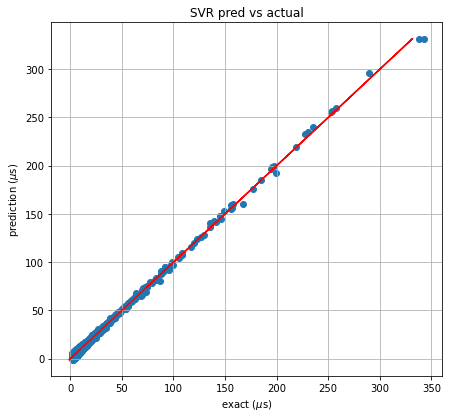

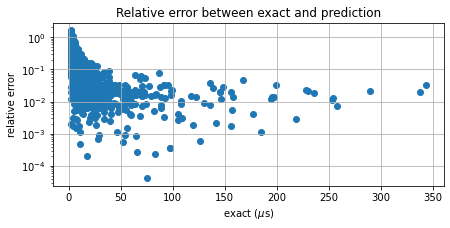

root mean square 1.7684831390785644e-06
average relative error 0.22098316105728644 +/- 0.25224848936906796
r squared 0.9967427602304509


In [28]:
# convert scale predictions and ys back
preds_times = scalery.inverse_transform(preds)
y_test_times = scalery.inverse_transform(y_test)

plt.figure(figsize=(7,6.5))
plt.scatter(y_test_times*1e6, preds_times*1e6)
plt.plot(preds_times*1e6 , preds_times*1e6, '-r')
plt.xlabel(r'exact ($\mu$s)')
plt.ylabel(r'prediction ($\mu$s)')
plt.title('SVR pred vs actual')
plt.grid()
plt.show()

rel_errors = np.abs((preds_times - y_test_times)/y_test_times)

plt.figure(figsize=(7,3))
plt.scatter(y_test_times*1e6, rel_errors)
plt.title('Relative error between exact and prediction')
plt.xlabel(r'exact ($\mu$s)')
plt.ylabel('relative error')
plt.yscale('log')
plt.grid()
plt.show()

print('root mean square', np.sqrt(np.mean((y_test_times - preds_times)**2)))
print('average relative error', np.mean(rel_errors), '+/-', np.std(rel_errors))
correlation_matrix = np.corrcoef(y_test_times, preds_times)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('r squared', r_squared)

## SVR for first-order optimal
Optimal is a bit tricky with ML models because for different numbers of pulses, the output pulse schedule has a different length with unique values. One way to account for this is to pad the training data outputs with zeros. Unfortunately, this will limit the model to the number of pulses considered in the training set and won't be able to extrapolate to higher numbers of pulses.

In [30]:
N_rand = 50

omegas = 2*np.pi * np.linspace(1/(2 * 1e-6), 1/(2 * 50e-6), 100)
omega_rands = np.random.choice(omegas, N_rand)

# Assume eta and initial nbar are computable from confining harmonic frequency omega_z
omega_zs = 2*np.pi * np.linspace(0.25, 6, 100) * 1e6
omega_z_rands = np.random.choice(omega_zs, N_rand)

lam = 355e-9
hbar = 1.05457e-34
m = 170.936 * 1.6605e-27
eta_rands = np.sqrt(2) * 2*np.pi/lam * np.sqrt(hbar/2/m/omega_z_rands)

initial_nbar_rands = 19.6e6/2/(omega_z_rands/2/np.pi)

N_pulses_rands = np.random.choice(np.arange(5, 40), N_rand)

strategy = 'optimal'
cooled_nbars = []
pulse_schedules = []
for omega_z, initial_nbar, omega, N_pulses in tqdm(zip(omega_z_rands, initial_nbar_rands, omega_rands, N_pulses_rands), total=len(omega_z_rands)):
    sim = simulation.SidebandCooling(omega_z, initial_nbar, omega)
    cooled_nbar, pulse_schedule, cooling_time, cooled_dist = sim.cool(strategy, N_pulses, 1)
    cooled_nbars.append(cooled_nbar)
    pulse_schedules.append(pulse_schedule[0])
    sim.reset_current_dist()

# Simulate and save data
pi_times = np.pi / omega_rands
dataX = np.column_stack((eta_rands, pi_times, initial_nbar_rands, N_pulses_rands))
dataY = np.array(pulse_schedules)

  4%|▍         | 2/50 [01:10<39:22, 49.23s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


  6%|▌         | 3/50 [02:12<41:23, 52.84s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 20%|██        | 10/50 [08:32<46:57, 70.43s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 24%|██▍       | 12/50 [09:23<28:36, 45.17s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 32%|███▏      | 16/50 [14:32<34:54, 61.60s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 36%|███▌      | 18/50 [15:57<25:40, 48.14s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 50%|█████     | 25/50 [19:15<13:02, 31.30s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 52%|█████▏    | 26/50 [20:00<14:08, 35.35s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 86%|████████▌ | 43/50 [31:08<04:54, 42.01s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 90%|█████████ | 45/50 [33:38<04:20, 52.07s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


 98%|█████████▊| 49/50 [39:05<01:06, 66.52s/it]

Bound error. Upper bound limited optimization. Increase upper bound.


100%|██████████| 50/50 [39:24<00:00, 47.30s/it]


In [31]:
# Save data into files
with open('data/dataX_opt.npy', 'wb') as f:
    np.save(f, dataX)
with open('data/dataY_opt.npy', 'wb') as f:
    np.save(f, dataY)

In [34]:
# load saved data
with open('data/dataX_opt.npy', 'rb') as f:
    dataX = np.load(f)
with open('data/dataY_opt.npy', 'rb') as f:
    dataY = np.load(f)

Preprocess data with a 1/3 test-train split and scale X and y

In [35]:
# Preprocess data
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42)

scalerX = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
X_train = scalerX.transform(X_train)
y_train = (scalery.transform(y_train.reshape(-1,1))).reshape(-1,)
X_test = scalerX.transform(X_test)
y_test = (scalery.transform(y_test.reshape(-1,1))).reshape(-1,)


Use cross-validation to tune SVR hyperparameters

In [36]:
svr = svm.SVR()

# select variety of SVR hyperparameters to try out
param_grid = [{'C': [10, 100, 1000, 5000, 10000], 'gamma': [0.005, 0.0075, 0.01, 0.02, 0.03, 0.04], 'kernel': ['rbf']}]
svr_grid = GridSearchCV(svr, param_grid, scoring='r2')
svr_grid.fit(X_train, y_train)

means = svr_grid.cv_results_['mean_test_score']
stds = svr_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr_grid.cv_results_['params']):
    print("%0.4f (+/-%0.04f) for %r"
          % (mean, std * 2, params))
print("Best parameters set found on development set:\n")
print(svr_grid.best_params_,"\n")
print("Grid scores on development set:\n")

0.1204 (+/-0.4084) for {'C': 10, 'gamma': 0.005, 'kernel': 'rbf'}
0.1559 (+/-0.4497) for {'C': 10, 'gamma': 0.0075, 'kernel': 'rbf'}
0.1649 (+/-0.4410) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.1710 (+/-0.4252) for {'C': 10, 'gamma': 0.02, 'kernel': 'rbf'}
0.1747 (+/-0.4397) for {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}
0.1835 (+/-0.4481) for {'C': 10, 'gamma': 0.04, 'kernel': 'rbf'}
0.2232 (+/-0.4460) for {'C': 100, 'gamma': 0.005, 'kernel': 'rbf'}
0.2390 (+/-0.4434) for {'C': 100, 'gamma': 0.0075, 'kernel': 'rbf'}
0.2457 (+/-0.4466) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.1257 (+/-0.3282) for {'C': 100, 'gamma': 0.02, 'kernel': 'rbf'}
-0.4851 (+/-1.5133) for {'C': 100, 'gamma': 0.03, 'kernel': 'rbf'}
-1.0385 (+/-3.6660) for {'C': 100, 'gamma': 0.04, 'kernel': 'rbf'}
0.2005 (+/-0.4104) for {'C': 1000, 'gamma': 0.005, 'kernel': 'rbf'}
-0.4486 (+/-2.1546) for {'C': 1000, 'gamma': 0.0075, 'kernel': 'rbf'}
-1.3313 (+/-4.0215) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [37]:
# Save otpimal hyperparameters, train, and predict on test data
gamma_opt = svr_grid.best_params_['gamma']
C_opt = svr_grid.best_params_['C']

# train SVR on training data
svr = svm.SVR(C=C_opt, gamma=gamma_opt)
svr.fit(X_train, y_train)

# compute predictions on test data
preds = svr.predict(X_test)

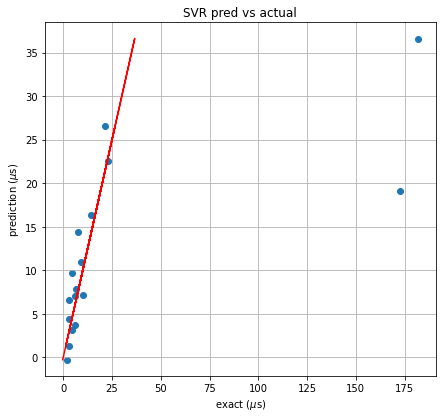

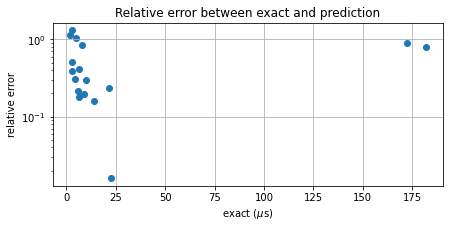

root mean square 5.1288214850871206e-05
average relative error 0.5261748422601579 +/- 0.3843683862809093
r squared 0.48339867431469


In [38]:
# convert scale predictions and ys back
preds_times = scalery.inverse_transform(preds)
y_test_times = scalery.inverse_transform(y_test)

plt.figure(figsize=(7,6.5))
plt.scatter(y_test_times*1e6, preds_times*1e6)
plt.plot(preds_times*1e6 , preds_times*1e6, '-r')
plt.xlabel(r'exact ($\mu$s)')
plt.ylabel(r'prediction ($\mu$s)')
plt.title('SVR pred vs actual')
plt.grid()
plt.show()

rel_errors = np.abs((preds_times - y_test_times)/y_test_times)

plt.figure(figsize=(7,3))
plt.scatter(y_test_times*1e6, rel_errors)
plt.title('Relative error between exact and prediction')
plt.xlabel(r'exact ($\mu$s)')
plt.ylabel('relative error')
plt.yscale('log')
plt.grid()
plt.show()

print('root mean square', np.sqrt(np.mean((y_test_times - preds_times)**2)))
print('average relative error', np.mean(rel_errors), '+/-', np.std(rel_errors))
correlation_matrix = np.corrcoef(y_test_times, preds_times)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print('r squared', r_squared)